<a href="https://colab.research.google.com/github/Paul-mwaura/ML-Hackathons/blob/main/Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np # linear algebra
import seaborn as sns 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [ ]:
# DataFrame to store all imported data
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['/content/combined_data_1.txt',
         '/content/combined_data_2.txt',
         '/content/combined_data_3.txt',
         '/content/combined_data_4.txt']

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()



Opening file: /content/combined_data_1.txt
Opening file: /content/combined_data_2.txt
Opening file: /content/combined_data_3.txt
Opening file: /content/combined_data_4.txt


In [ ]:
# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['movie_id', 
                                    'user_id',
                                    'rating',
                                    'date'])

df

,movie_id,user_id,rating,date
0,1,1488844,3.0,2005-09-06
1,1,822109,5.0,2005-05-13
2,1,885013,4.0,2005-10-19
3,1,30878,4.0,2005-12-26
4,1,823519,3.0,2004-05-03
...,...,...,...,...
6215946,13614,1476458,1.0,2001-01-09
6215947,13614,942709,4.0,2005-07-17
6215948,13614,2099824,4.0,2005-07-17
6215949,13614,1865887,4.0,2003-06-27


In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
#no need to use the df_movie
#continue df

#pre-process stage

lite_rating_df = pd.DataFrame()

group = df.groupby('user_id')['rating'].count()
top_users = group.sort_values(ascending=False)[:20000]

group = df.groupby('movie_id')['rating'].count()
top_movies = group.sort_values(ascending=False)[:4000]

lite_rating_df = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
lite_rating_df = lite_rating_df.join(top_movies, rsuffix='_r', how='inner', on='movie_id')

# Re-name the users and movies for uniform name from 0..2000 and 10000
user_enc = LabelEncoder()
lite_rating_df['user'] = user_enc.fit_transform(lite_rating_df['user_id'].values)
movie_enc = LabelEncoder()
lite_rating_df['movie'] = movie_enc.fit_transform(lite_rating_df['movie_id'].values)

n_movies = lite_rating_df['movie'].nunique()
n_users = lite_rating_df['user'].nunique()

# print(n_movies, n_users)
lite_rating_df

,movie_id,user_id,rating,date,rating_r,rating_r,user,movie
0,1,1488844,3.0,2005-09-06,146,547,11248,0
3,1,30878,4.0,2005-12-26,93,547,228,0
7,1,1248029,3.0,2004-04-22,100,547,9417,0
19,1,372233,5.0,2005-11-23,72,547,2728,0
20,1,1080361,3.0,2005-03-28,79,547,8133,0
...,...,...,...,...,...,...,...,...
1531623,4505,2520364,1.0,2005-10-20,93,238,19020,317
1531636,4505,2399030,1.0,2005-11-08,75,238,18055,317
1531595,4505,907347,3.0,2005-10-30,62,238,6812,317
1531445,4505,1283137,2.0,2005-11-18,104,238,9697,317


In [ ]:
top_users[:5]

user_id
305344     1177
387418     1166
2439493    1115
1664010    1063
2118461     974
Name: rating, dtype: int64

In [ ]:
top_movies[:5]

movie_id
9340     173596
4656     130782
4640     122158
13462    118884
30       118413
Name: rating, dtype: int64

In [ ]:
lite_rating_df.isnull().sum()#dataset no null values

movie_id    0
user_id     0
rating      0
date        0
rating_r    0
rating_r    0
user        0
movie       0
dtype: int64

In [ ]:
X = lite_rating_df[['user', 'movie']].values
y = lite_rating_df['rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

print(f"X Train: {X_train.shape}\nX Test: {X_test.shape}\n")
print(f"Y Train: {Y_train.shape}\nY Test: {Y_test.shape}\n")

X Train: (1328616, 2)
X Test: (164027, 2)

Y Train: (1312214,)
Y Test: (328054,)



In [ ]:
# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(user)
u = Reshape((e_dimension,))(u)

movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(movie)
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
# Build last deep learning layers 
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.001), 
              metrics=[tf.keras.metrics.Accuracy()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 50)        1000000     input_21[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 50)        59350       input_22[0][0]                   
___________________________________________________________________________________________

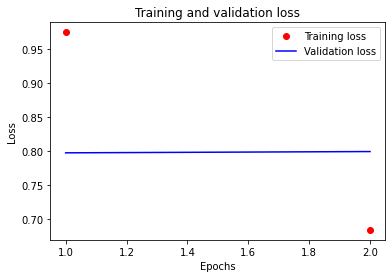

In [ ]:
# Visualize the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

0.87932473

In the test result, we can see that our model's RMSE is 0.87932473, which is quite good